# Multi Fidelity optimization

In [1]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from functools import partial

from jax import jit
from jax import lax
from jax import nn
from jax import numpy as jnp
from jax import random
from jax import value_and_grad
from jax import scipy
from jax import vmap

import optax
import matplotlib.pyplot as plt

from boax.core import distributions, samplers
from boax.prediction import kernels, likelihoods, means, models
from boax.optimization import acquisitions, maximizers

In [2]:
bounds = jnp.array([[-5.0, 5.0]])

In [3]:
def objective(x):
    return -((x[..., 0] + 1) ** 2) * jnp.sin(2 * x[..., 0] + 2) / 5 + 1 + x[..., 0] / 3
 
def approximate(x):
    return 0.5 * objective(x) + x[..., 0] / 4 + 2

In [4]:
fidelities = jnp.array([0.5, 1.0])

In [5]:
data_key, sampler_key, maximizer_key = random.split(random.key(0), 3)

f_train = random.randint(random.fold_in(data_key, 0), minval=0, maxval=2, shape=(10,))

x_train = random.uniform(random.fold_in(data_key, 1), minval=bounds[:, 0], maxval=bounds[:, 1], shape=(10, 1))
x_fid = fidelities[f_train][..., jnp.newaxis]

y_obj = objective(x_train)
y_approx = approximate(x_train)

x_train_full = jnp.hstack([x_train, x_fid])
y_train = jnp.where(f_train, y_obj, y_approx)

In [6]:
xs = jnp.linspace(-5, 5, 501)[..., jnp.newaxis]
ys_obj = objective(xs)
ys_approx = approximate(xs)

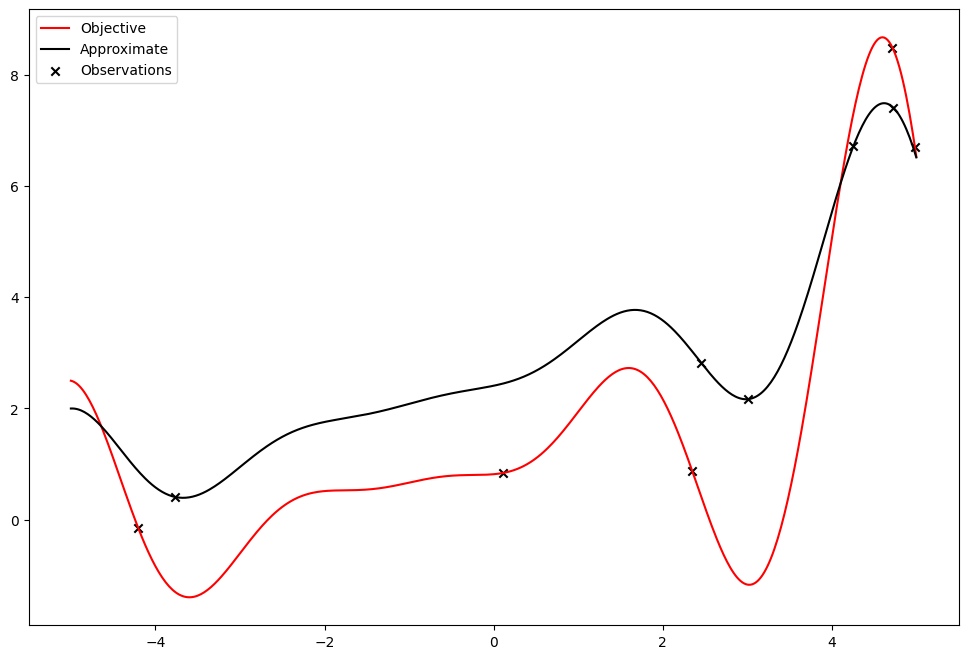

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xs, ys_obj, color='r', label='Objective')
ax.plot(xs, ys_approx, linestyle='-', color='k', label='Approximate')
ax.scatter(x_train, y_train, marker='x', color='k', label='Observations')

plt.legend()
plt.show()

In [8]:
params = {
    'constant': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
    'unbiased_length_scale': jnp.zeros(()),
    'biased_length_scale': jnp.zeros(()),
    'power': jnp.zeros(()),
}

In [9]:
optimizer = optax.adam(0.01)

In [12]:
s, n, q, d = 128, 10, 3, 2

In [18]:
base_samples = jnp.reshape(
    samplers.halton_normal()(random.fold_in(sampler_key, 0), s * n * q),
    (s, n, q)
)

In [19]:
fantasies = jnp.reshape(
    samplers.halton_uniform(distributions.uniform.uniform(bounds[:, 0], bounds[:, 1]))(random.fold_in(sampler_key, 3), s * n),
    (s, n, 1, -1)
)

In [10]:
def fit(x_train, y_train):
    def prior(constant, amplitude, unbiased_length_scale, biased_length_scale, power):
        return models.predictive(
            models.gaussian_process(
                means.constant(constant),
                kernels.scaled(
                    kernels.linear_truncated(
                        x_fid,
                        x_fid,
                        kernels.matern_five_halves(nn.softplus(unbiased_length_scale)),
                        kernels.matern_five_halves(nn.softplus(biased_length_scale)),
                        nn.softplus(power)
                    ),
                    nn.softplus(amplitude)
                ),
            ),
            likelihoods.gaussian(1e-4),
        )

    def posterior(constant, amplitude, unbiased_length_scale, biased_length_scale, power):
        return models.predictive(
            models.multi_fidelity_regression(
                means.constant(constant),
                lambda fid1, fid2: kernels.scaled(
                    kernels.linear_truncated(
                        fid1,
                        fid2,
                        kernels.matern_five_halves(nn.softplus(unbiased_length_scale)),
                        kernels.matern_five_halves(nn.softplus(biased_length_scale)),
                        nn.softplus(power)
                    ),
                    nn.softplus(amplitude)
                )
            )(
                x_train,
                y_train,
            ),
            likelihoods.gaussian(1e-4),
        )
    
    def target_log_prob(params):
        mvn = prior(**params)(x_train[..., :-1])
        return -jnp.sum(distributions.multivariate_normal.logpdf(mvn, y_train))

    def train_step(state, iteration):
        loss, grads = value_and_grad(target_log_prob)(state[0])
        updates, opt_state = optimizer.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)
        
        return (params, opt_state), loss
    
    (next_params, next_opt_state), history = lax.scan(
        jit(train_step),
        (params, optimizer.init(params)),
        jnp.arange(500)
    )

    return posterior(**next_params)

In [14]:
candidates = jnp.reshape(
    samplers.halton_uniform(distributions.uniform.uniform(bounds[:, 0], bounds[:, 1]))(random.fold_in(sampler_key, 1), n * q),
    (n, q, -1)
)

In [29]:
fidelities = jnp.reshape(
    samplers.halton_uniform()(random.fold_in(sampler_key, 2), n * q),
    (n, q, -1)
)

In [11]:
surrogate = fit(x_train_full, y_train)

In [ ]:
mvn = surrogate(jnp.hstack([xs, jnp.ones_like(xs)]))

In [ ]:
norm = distributions.multivariate_normal.as_normal(mvn)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xs, ys_obj, color='r', label='Objective')
ax.plot(xs, ys_approx, linestyle='-', color='k', label='Approximate')

ax.plot(xs, norm.loc, linestyle='dotted', color='b', label='Prediction')
ax.fill_between(
    xs[..., 0],
    norm.loc - 2 * norm.scale,
    norm.loc + 2 * norm.scale,
    color='b', label='95% CI',
    alpha=0.3
)

ax.scatter(x_train, y_train, marker='x', color='k', label='Observations')

plt.legend()
plt.show()

In [20]:
fantasy = models.predictive(
    models.fantasized(
        models.sampled(
            vmap(surrogate),
            vmap(distributions.multivariate_normal.sample),
            base_samples
        ),
        models.multi_fidelity_fantasy(
            means.constant(params['constant']),
            lambda fid1, fid2: kernels.scaled(
                kernels.linear_truncated(
                    fid1,
                    fid2,
                    kernels.matern_five_halves(nn.softplus(params['unbiased_length_scale'])),
                    kernels.matern_five_halves(nn.softplus(params['biased_length_scale'])),
                    nn.softplus(params['power'])
                ),
                nn.softplus(params['amplitude'])
            ),
        ),
        fantasies
    ),
    likelihoods.gaussian(1e-4)
)

In [44]:
values = jnp.concatenate([candidates, fidelities], axis=-1)

In [45]:
qKG = acquisitions.q_knowledge_gradient(
    models.outcome_transformed(
        fantasy,
        vmap(vmap(distributions.multivariate_normal.as_normal))
    ),
    best=0.0
)

In [47]:
models.outcome_transformed(
    fantasy,
    vmap(vmap(distributions.multivariate_normal.as_normal))
)(values)

Normal(loc=Array([[[         nan],
        [  1.42430828],
        [         nan],
        ...,
        [  2.965184  ],
        [         nan],
        [ -7.76468746]],

       [[         nan],
        [  4.29486148],
        [         nan],
        ...,
        [ -2.63379301],
        [         nan],
        [  7.25762367]],

       [[         nan],
        [ -3.09869759],
        [  6.18865403],
        ...,
        [ -0.13196673],
        [         nan],
        [-12.09751724]],

       ...,

       [[         nan],
        [  8.09421658],
        [         nan],
        ...,
        [ -9.32169886],
        [         nan],
        [  1.60681174]],

       [[         nan],
        [-10.71361949],
        [  7.00069718],
        ...,
        [  2.46085222],
        [         nan],
        [ -5.64972582]],

       [[  4.68556764],
        [ 11.91832462],
        [         nan],
        ...,
        [-11.61771923],
        [  9.34528712],
        [ 10.30740382]]], dtype=float64), scale=

In [37]:
acqf = acquisitions.q_multi_fidelity_knowledge_gradient(
    models.outcome_transformed(
        fantasy,
        vmap(vmap(distributions.multivariate_normal.as_normal))
    ),
    cost,
    best=0.0,
)

In [39]:
result = acqf(values)